## Run bayesian inference

the notebook start by first loading the model config and checking the data, 

then you can run the sampling either in the HPC or in the notebook

In [1]:
# load the relevant modules for the analysis

import os
from pathlib import Path

import pandas as pd

from pl_temp_fit import (
    Exp_data_utils,
    config_utils,
    HPC_utils,
)

# access the right directory
os.chdir("..")

In [2]:
# get test_ids in the database
config_folder = "allLifetimes"

path_database = Path(
    f"fit_experimental_emcee_pl/fit_data_base/{config_folder}"
)
model_config_files = list(path_database.glob("*.json"))
test_id_list = []

list_model_config = []
for id, model_config_file in enumerate(model_config_files):
    # print(id,model_config_file)
    test_id = model_config_file.name.replace(".json", "")
    test_id_list.append(test_id)
    model_config, model_config_save = config_utils.load_model_config(
        test_id, database_folder=path_database
    )
    # print(model_config_save["csv_name_pl"].split("/")[-1])
    list_model_config.append(model_config_save)

if len(list_model_config) == 0:
    print("no data")
else:
    df_all = pd.DataFrame(list_model_config)
    df_all.sort_values(by="date", ascending=False, inplace=True)
df_all["csv_name_pl"] = df_all["csv_name_pl"].apply(lambda x: x.split("/")[-1])
df_all.dropna(subset=["temperature_lifetimes_exp"], inplace=True)
print("number of data points", len(df_all))
df_all[
    [
        "csv_name_pl",
        "params_to_fit_init",
        "min_bounds",
        "max_bounds",
        "test_id",
        "temperature_lifetimes_exp",
    ]
].head(10)


number of data points 17


,csv_name_pl,params_to_fit_init,min_bounds,max_bounds,test_id,temperature_lifetimes_exp
0,IEICOcn-2_cb-300K_G0_750.0nm_1600.0nm_16-07-20...,"{'EX': {'E': 1.5, 'sigma': 0.1, 'Li': 0.078, '...","{'EX': {'E': 1.4, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.6, 'sigma': 0.2, 'Li': 0.2, 'Lo...",09fa1cc8-c48e-4c55-8023-f38e3b05492f,"{'300': 3e-10, '260': 2.9e-10, '220': 2.8e-10,..."
9,GSISO-300K_G0_600.0nm_1250.0nm_07-07-2024-16h-...,"{'EX': {'E': 1.83, 'sigma': 0.1, 'Li': 0.078, ...","{'EX': {'E': 1.75, 'sigma': 0.001, 'Li': 0.01,...","{'EX': {'E': 1.9, 'sigma': 0.2, 'Li': 0.2, 'Lo...",79e6addc-37c3-43fe-ac33-e2f2890706f4,"{'300': 4.9e-10, '260': 6.7e-10, '220': 7e-10,..."
15,Y5-300K-sync2_G0_750.0nm_1400.0nm_15-10-2024-1...,"{'EX': {'E': 1.46, 'sigma': 0.1, 'Li': 0.078, ...","{'EX': {'E': 1.4, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.53, 'sigma': 0.2, 'Li': 0.2, 'L...",482611b3-a109-456e-99c6-d9acae012faf,"{'300': 1.33e-09, '260': 1.66e-09, '220': 1.69..."
14,IT4F-300K-9_G0_650.0nm_1450.0nm_12-07-2024-12h...,"{'EX': {'E': 1.6, 'sigma': 0.1, 'Li': 0.078, '...","{'EX': {'E': 1.5, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.7, 'sigma': 0.2, 'Li': 0.2, 'Lo...",8a5cb72c-0ad0-49f8-9c39-87e22285b069,"{'300': 3.9e-10, '260': 4.2e-10, '220': 5e-10,..."
13,IEICO_cb-300K_G0_750.0nm_1600.0nm_16-07-2024-1...,"{'EX': {'E': 1.5, 'sigma': 0.1, 'Li': 0.078, '...","{'EX': {'E': 1.4, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.6, 'sigma': 0.2, 'Li': 0.2, 'Lo...",77f0197f-8607-4360-86cb-c59148fa1fbe,"{'300': 3.4e-10, '260': 3.3e-10, '220': 3.3e-1..."
12,Y6-brilliantmat-DIO-fresh-300K_G0_mod_split0_s...,"{'EX': {'E': 1.4, 'sigma': 0.1, 'Li': 0.078, '...","{'EX': {'E': 1.3, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.5, 'sigma': 0.2, 'Li': 0.2, 'Lo...",6ecb03ab-0512-4de7-9e42-11440cfd11be,"{'300': 6.6e-10, '260': 7.9e-10, '220': 8.5e-1..."
11,IEICO4F_cb-300K_G0_820.0nm_1600.0nm_17-07-2024...,"{'EX': {'E': 1.44, 'sigma': 0.1, 'Li': 0.078, ...","{'EX': {'E': 1.4, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.55, 'sigma': 0.2, 'Li': 0.2, 'L...",94ac833c-8019-4af9-805e-2cc449d055dd,"{'300': 2.1e-10, '260': 1.9e-10, '220': 1.7e-1..."
10,L8BO-fresh-300K_G0_750.0nm_1350.0nm_15-06-2024...,"{'EX': {'E': 1.47, 'sigma': 0.1, 'Li': 0.078, ...","{'EX': {'E': 1.5, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.7, 'sigma': 0.2, 'Li': 0.2, 'Lo...",732eacab-c622-4e02-a720-d5d89121883b,"{'300': 9.4e-10, '260': 9.9e-10, '220': 1.08e-..."
8,L8BO-fresh-300K_G0_750.0nm_1350.0nm_15-06-2024...,"{'EX': {'E': 1.47, 'sigma': 0.1, 'Li': 0.078, ...","{'EX': {'E': 1.5, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.7, 'sigma': 0.2, 'Li': 0.2, 'Lo...",dd50ffff-7414-49ea-8df0-d4efbbc4be6f,"{'300': 9.4e-10, '260': 9.9e-10, '220': 1.08e-..."
1,IT4FDIO-300K-9_G0_650.0nm_1450.0nm_12-07-2024-...,"{'EX': {'E': 1.6, 'sigma': 0.1, 'Li': 0.078, '...","{'EX': {'E': 1.5, 'sigma': 0.001, 'Li': 0.01, ...","{'EX': {'E': 1.7, 'sigma': 0.2, 'Li': 0.2, 'Lo...",d0abcab7-f28e-4f43-aae4-6de279345666,"{'300': 4.1e-10, '260': 5.9e-10, '220': 7.3e-1..."


In [8]:
import importlib

# load and update the model config
importlib.reload(config_utils)
script_to_run = "new_pl_sampling_alllifetimes_abs"
new_path = "/media/mohammed/Work/pl_temp_fit/dat_hanbo_311024/csv"
new_path_save_folder = "/media/mohammed/Work/pl_temp_fit/fit_experimental_emcee_pl/fit_data"

for test_id in df_all["test_id"].values:
    model_config, model_config_save = config_utils.load_model_config(
        test_id, database_folder=path_database
    )
    csv_name = model_config_save["csv_name_pl"]
    print(model_config_save["csv_name_pl"].split("/")[-1])
    model_config_save = config_utils.update_csv_name_pl(
        model_config_save,
        csv_name,
        new_path,
        new_path_save_folder,
        script_to_run,
        test_id,
    )
    config_utils.updata_model_config(test_id, path_database, model_config_save)
    HPC_utils.save_slurm_script(
        test_id, script_to_run, model_config_save, config_folder
    )

IEICOcn-2_cb-300K_G0_750.0nm_1600.0nm_16-07-2024-12h-45m_Exposure_5.0s.csv
IEICOcn-2_cb-300K_G0_750.0nm_1600.0nm_16-07-2024-12h-45m_Exposure_5.0s_new_pl_sampling_alllifetimes_abs.sh
GSISO-300K_G0_600.0nm_1250.0nm_07-07-2024-16h-58m_Exposure_1.0s_mod_split0_split500.csv
GSISO-300K_G0_600.0nm_1250.0nm_07-07-2024-16h-58m_Exposure_1.0s_mod_split0_split500_new_pl_sampling_alllifetimes_abs.sh
Y5-300K-sync2_G0_750.0nm_1400.0nm_15-10-2024-15h-34m_Exposure_2.0s_mod_split0_split500.csv
Y5-300K-sync2_G0_750.0nm_1400.0nm_15-10-2024-15h-34m_Exposure_2.0s_mod_split0_split500_new_pl_sampling_alllifetimes_abs.sh
IT4F-300K-9_G0_650.0nm_1450.0nm_12-07-2024-12h-55m_Exposure_2.0s_mod_split0_split500.csv
IT4F-300K-9_G0_650.0nm_1450.0nm_12-07-2024-12h-55m_Exposure_2.0s_mod_split0_split500_new_pl_sampling_alllifetimes_abs.sh
IEICO_cb-300K_G0_750.0nm_1600.0nm_16-07-2024-12h-41m_Exposure_5.0s.csv
IEICO_cb-300K_G0_750.0nm_1600.0nm_16-07-2024-12h-41m_Exposure_5.0s_new_pl_sampling_alllifetimes_abs.sh
Y6-brilliant

Y6-brilliantmat-DIO-fresh-300K_G0_mod_split0_split500_mod_split0_split500.csv
shape of mean value plot is (65, 7)


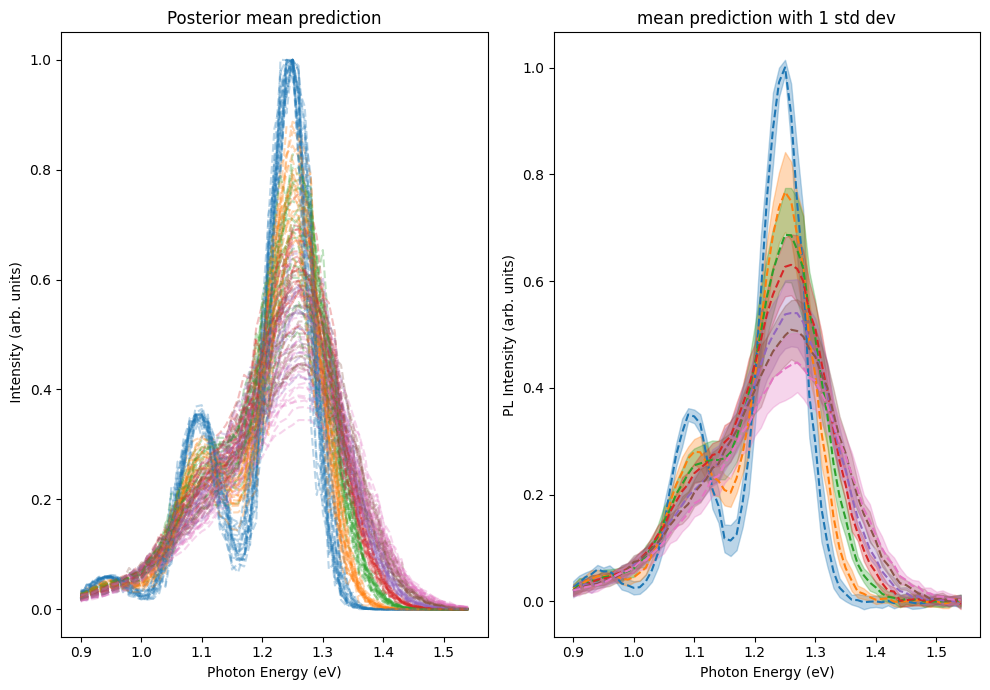

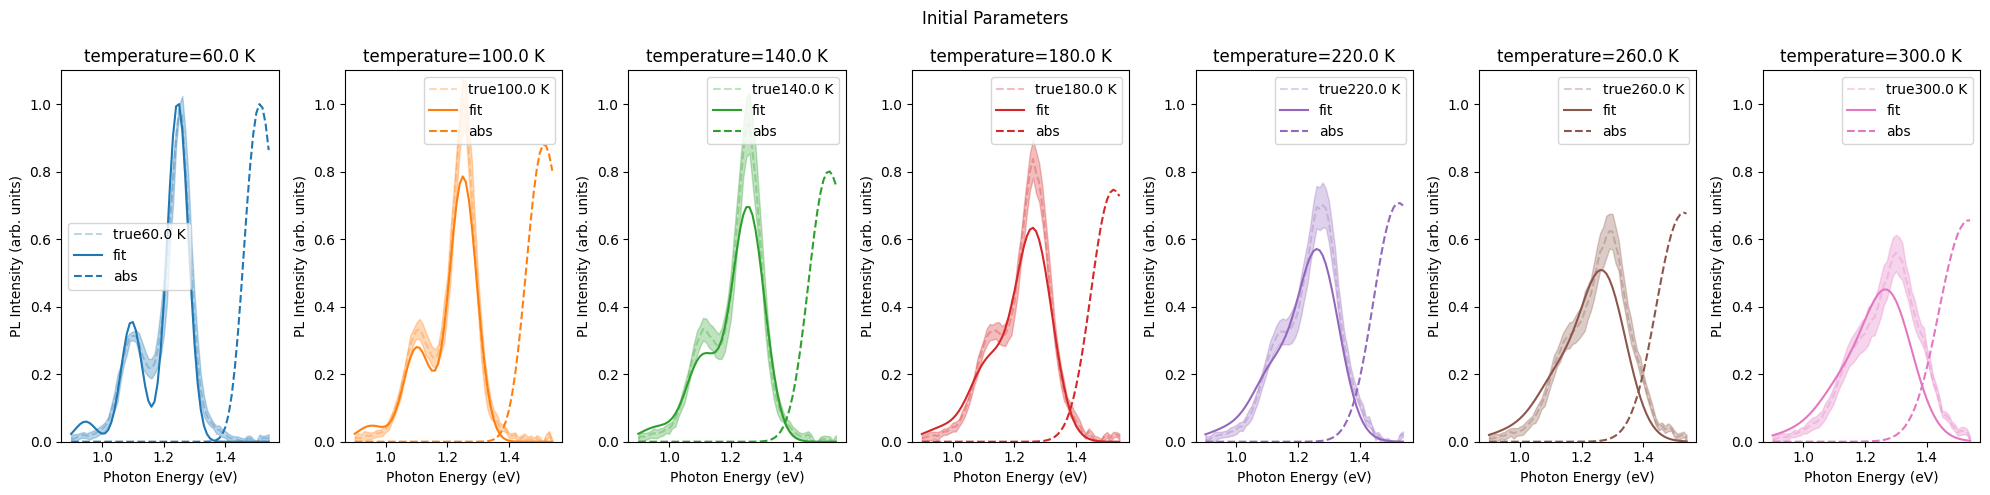

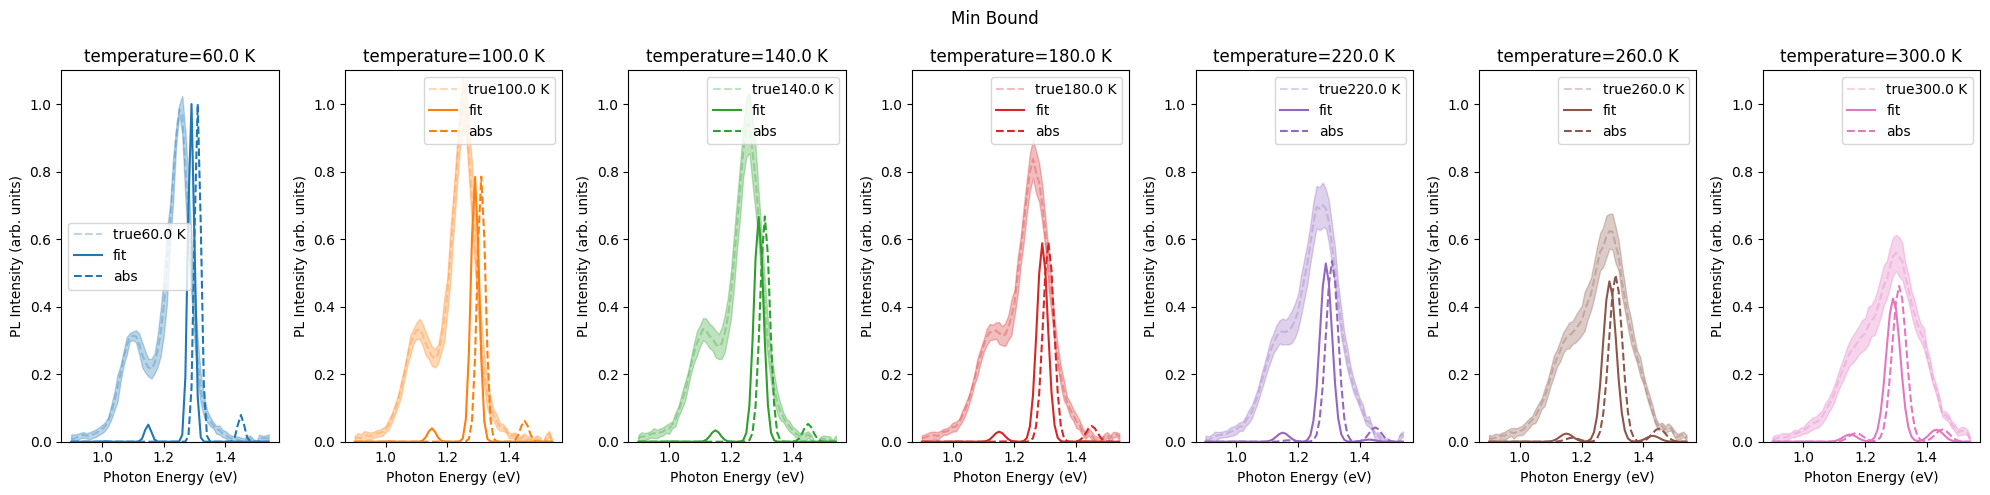

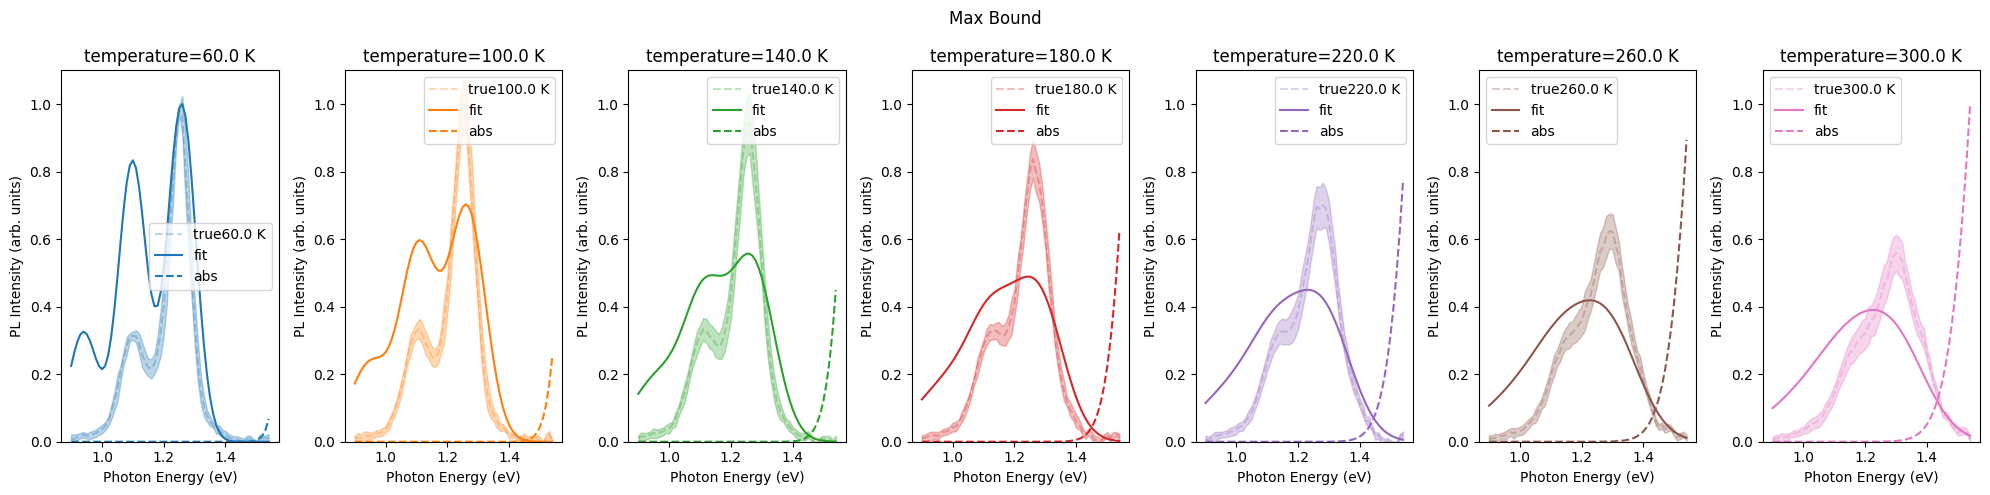

In [9]:
# plot the results with initial parameters
# and the maximum and minumum bounds
import importlib

from pl_temp_fit import fit_pl_utils

importlib.reload(fit_pl_utils)
test_id = df_all["test_id"].values[5]
print(df_all["csv_name_pl"].values[5])
model_config, model_config_save = config_utils.load_model_config(
    test_id, database_folder=path_database
)
fit_pl_utils.plot_fit_limits(model_config, model_config_save)


### run sampler in the notebook

In [10]:
import emcee

filename = model_config_save["save_folder"] + "/sampler.h5"
if os.path.exists(filename):
    try:
        reader = emcee.backends.HDFBackend(filename, name="multi_core")
        distribution = reader.get_chain(discard=0, flat=True)
        true_parameters = fit_pl_utils.get_param_dict(
            model_config_save["params_to_fit_init"], distribution[-1]
        )
    except AttributeError:
        print("no sampler found")
        true_parameters = model_config_save["params_to_fit_init"]
else:
    true_parameters = model_config_save["params_to_fit_init"]
    print("no sampler found")

no sampler found


In [11]:
from pl_temp_fit import fit_pl_utils
from pl_temp_fit.data_generators import PLAbsAndLifetimeEVER

csv_name_pl = model_config_save["csv_name_pl"]
save_folder = model_config_save["save_folder"]
Path(save_folder).mkdir(parents=True, exist_ok=True)
# Load the data
Exp_data_pl, temperature_list_pl, hws_pl = Exp_data_utils.read_data(
    csv_name_pl
)
# initialising the data generator
pl_data_gen = PLAbsAndLifetimeEVER.PLAbsAndLifetimeEVER(
    temperature_list_pl, hws_pl
)
pl_data_gen.relative_error_lifetime = model_config_save[
    "relative_error_lifetime"
]
pl_data_gen.error_in_max_abs_pos = model_config_save["error_in_max_abs_pos"]
pl_data_gen.max_abs_pos_exp = model_config_save["max_abs_pos_exp"]
pl_data_gen.temperature_lifetimes_exp = model_config_save[
    "temperature_lifetimes_exp"
]
pl_data_gen.update_with_model_config(model_config_save)

co_var_mat_pl, variance_pl = pl_data_gen.get_covariance_matrix()
# getting the maximum likelihood estimate
get_maximum_likelihood_estimate = False
fit_pl_utils.run_sampler_parallel(
    save_folder,
    Exp_data_pl,
    co_var_mat_pl,
    pl_data_gen,
    nsteps=5,  # model_config_save["nsteps"],
    coeff_spread=model_config_save["coeff_spread"],
    num_coords=model_config_save["num_coords"],
    restart_sampling=True,
)


num_processes = 32


100%|██████████| 5/5 [00:12<00:00,  2.46s/it]

multi process took 15.1 seconds


### run sampling in the HPC


In [ ]:
model_config_id = test_id
csv_name = model_config_save["csv_name_pl"]
results_name = csv_name.replace(".csv", "").split("/")[-1]
sh_name = f"Run_EMCEE_{results_name}.sh"
script = (
    "#!/bin/bash \n"
    + "#PBS -l walltime=07:59:01 \n"
    + "#PBS -l select=1:ncpus=32:mem=80gb:avx=true \n"
    + " \n"
    + "cd /rds/general/user/hy2120/home/pl_temp_fit/ \n"
    + "module load anaconda3/personal \n"
    + "source activate pl_temp_fit     \n"
    + f"python src/pl_temp_fit/scripts/run_pl_sampling.py --model_config_id {model_config_id} \n"
)  # ${'PBS_ARRAY_INDEX'}#f"#PBS -J 1-{16} \n"+\
print(script)
with open(f"HPC_bash_script/{sh_name}", "wb") as f:
    f.write(bytes(script, "utf-8"))
script = (
    f"qsub  -e ./cache -o ./cache HPC_bash_script/{sh_name}"  # submit to HPC
)
os.system(script)

#!/bin/bash 
#PBS -l walltime=07:59:01 
#PBS -l select=1:ncpus=32:mem=80gb:avx=true 
 
cd /rds/general/user/hy2120/home/pl_temp_fit/ 
module load anaconda3/personal 
source activate pl_temp_fit     
python src/pl_temp_fit/scripts/run_pl_sampling.py --model_config_id 7fc02986-c5b0-4134-9b12-e009e90280e3 

26576.pbs


0

to run the scipt using the hpc you can just submit the job above

if you want ot run the job on the terminal you can run the script from the folder of pl_temp_fit using  for example

        python src/pl_temp_fit/scripts/run_pl_sampling.py --model_config_id e7ed53f3-f1ef-46c2-9b98-35b366e9f04d 

where e7ed53f3-f1ef-46c2-9b98-35b366e9f04d  correspond to your model config id